In [2]:
!pip install scikit-learn


   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/8.7 MB 5.6 MB/s eta 0:00:02
   --------- ------------------------------ 2.1/8.7 MB 5.9 MB/s eta 0:00:02
   -------------- ------------------------- 3.1/8.7 MB 5.3 MB/s eta 0:00:02
   -------------------- ------------------- 4.5/8.7 MB 5.6 MB/s eta 0:00:01
   --------------------------- ------------ 6.0/8.7 MB 6.2 MB/s eta 0:00:01
   ---------------------------------- ----- 7.6/8.7 MB 6.3 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 6.5 MB/s  0:00:01
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   -- ------------------------------------- 2.1/38.6 MB 9.8 MB/s eta 0:00:04
   --- ------------------------------------ 3.4/38.6 MB 8.0 MB/s eta 0:00:05
   ---- ----------------------------------- 3.9/38.6 MB 6.9 MB/s eta 0:00:06
   ----- ---------------------------------- 5.0/38.6 MB 5.9 MB/s eta 0:00:06
   ------ --------------

In [3]:
!pip install pillow


In [4]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


In [6]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
SEED = 123
DATA_DIR = r"C:\Pre\Disease_Dataset"   # <-- update this to your Dataset folder that contains ALL, AML, CLL, CML, NORMAL
MODEL_SAVE_PATH = "leukemia_cnn_model.h5"

In [8]:
# Cell 2
classes = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
print("Detected class folders:", classes)

# Print counts per folder (images)
counts = {}
for c in classes:
    p = os.path.join(DATA_DIR, c)
    # count files (common image extensions)
    files = []
    for ext in ("*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff"):
        files.extend(tf.io.gfile.glob(os.path.join(p, ext)))
    counts[c] = len(files)
    print(f"  {c}: {counts[c]} images")

# Ensure expected 5 classes exist
assert len(classes) == 5, f"Expected 5 classes but found {len(classes)}: {classes}"


Detected class folders: ['ALL', 'AML', 'CLL', 'CML', 'Normal']
  ALL: 1000 images
  AML: 1000 images
  CLL: 1000 images
  CML: 1000 images
  Normal: 4000 images


In [9]:
# Cell 3
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="int",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="training",
)

val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="int",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="validation",
)

class_names = train_ds.class_names
n_classes = len(class_names)
print("class_names (inferred):", class_names)


Found 8000 files belonging to 5 classes.
Using 6400 files for training.
Found 8000 files belonging to 5 classes.
Using 1600 files for validation.
class_names (inferred): ['ALL', 'AML', 'CLL', 'CML', 'Normal']


In [10]:
# Cell 4
val_batches = tf.data.experimental.cardinality(val_test_ds).numpy() // 2
val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())


Train batches: 200
Val batches: 25
Test batches: 25


In [11]:
# Cell 5
AUTOTUNE = tf.data.AUTOTUNE
normalization = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal", seed=SEED),
    layers.RandomRotation(0.06, seed=SEED),
    layers.RandomZoom(0.06, seed=SEED),
], name="data_augmentation")

def prepare(ds, shuffle=False, augment=False):
    if shuffle:
        ds = ds.shuffle(1000, seed=SEED)
    def _process(x, y):
        x = normalization(x)
        if augment:
            x = data_augmentation(x)
        return x, y
    ds = ds.map(_process, num_parallel_calls=AUTOTUNE)
    return ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds, shuffle=False, augment=False)
test_ds = prepare(test_ds, shuffle=False, augment=False)


In [12]:

# Cell 6
# If you prefer to compute from folder counts above, use that.
# But since you provided exact counts, we'll use them to create stable class_weights.
# Make sure class_names order matches the order here.
# Map: class_names -> counts
print("class_names inferred order:", class_names)
# Map counts by class_names (fallback to detected counts if provided ones differ)
provided_counts = {"ALL":1005, "AML":1000, "CLL":1000, "CML":1000, "NORMAL":4000}

# Build counts array matching class_names order
count_list = []
for cname in class_names:
    if cname in provided_counts:
        count_list.append(provided_counts[cname])
    else:
        # fallback to detected counts (from scanning folder)
        count_list.append(counts.get(cname, 0))

count_arr = np.array(count_list)
print("Counts in class_names order:", dict(zip(class_names, count_arr)))

# compute class_weights manually (balanced formula)
total = count_arr.sum()
n_classes = len(count_arr)
class_weights = {i: float(total / (n_classes * count_arr[i])) for i in range(n_classes)}
print("Class weights:", class_weights)


class_names inferred order: ['ALL', 'AML', 'CLL', 'CML', 'Normal']
Counts in class_names order: {'ALL': np.int64(1005), 'AML': np.int64(1000), 'CLL': np.int64(1000), 'CML': np.int64(1000), 'Normal': np.int64(4000)}
Class weights: {0: 1.5930348258706468, 1: 1.601, 2: 1.601, 3: 1.601, 4: 0.40025}


In [13]:
# Cell 7
def build_cnn(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=n_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_cnn()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 457,413 (1.74 MB)

 Trainable params: 456,453 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

In [14]:
# Cell 8
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [15]:
# Cell 9
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

os.makedirs("Models", exist_ok=True)
callbacks = [
    EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7),
    ModelCheckpoint("Models/best_cnn.h5", monitor="val_loss", save_best_only=True)
]


In [16]:
# Cell 10
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)
# Save in both formats
model.save("leukemia_cnn_model.h5")      # Legacy HDF5 format
model.save("leukemia_cnn_model.keras")   # New recommended Keras format

print("Model saved successfully!")


Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7244 - loss: 0.9351

200/200 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.7950 - loss: 0.7445 - val_accuracy: 0.1425 - val_loss: 3.0496 - learning_rate: 1.0000e-04
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8637 - loss: 0.5643

200/200 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.8670 - loss: 0.5365 - val_accuracy: 0.1437 - val_loss: 2.9590 - learning_rate: 1.0000e-04
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8767 - loss: 0.4865

200/200 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.8841 - loss: 0.4640 - val_accuracy: 0.8487 - val_loss: 0.4083 - learning_rate: 1.0000e-04
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8853 - loss: 0.4254

200/200 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.8931 - loss: 0.4086 - val_accuracy: 0.8288 - val_loss: 0.3943 - learning_rate: 1.0000e-04
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.9087 - loss: 0.3712 - val_accuracy: 0.8313 - val_loss: 0.4834 - learning_rate: 1.0000e-04
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9121 - loss: 0.3507

200/200 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.9158 - loss: 0.3331 - val_accuracy: 0.8850 - val_loss: 0.3129 - learning_rate: 1.0000e-04
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.9217 - loss: 0.3069 - val_accuracy: 0.8687 - val_loss: 0.3849 - learning_rate: 1.0000e-04
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9294 - loss: 0.2915

200/200 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.9317 - loss: 0.2754 - val_accuracy: 0.9000 - val_loss: 0.2374 - learning_rate: 1.0000e-04
Epoch 9/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9344 - loss: 0.2734

200/200 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.9417 - loss: 0.2509 - val_accuracy: 0.9137 - val_loss: 0.1921 - learning_rate: 1.0000e-04
Epoch 10/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.9456 - loss: 0.2260 - val_accuracy: 0.8850 - val_loss: 0.3187 - learning_rate: 1.0000e-04
Epoch 11/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.9544 - loss: 0.2033 - val_accuracy: 0.8537 - val_loss: 0.4140 - learning_rate: 1.0000e-04
Epoch 12/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.9564 - loss: 0.1865 - val_accuracy: 0.8450 - val_loss: 0.4585 - learning_rate: 1.0000e-04
Epoch 13/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.9708 - loss: 0.1428 - val_accuracy: 0.8700 - val_loss: 0.3656 - learning_rate: 5.0000e-05
Epoch 14/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.9694 - loss: 0.1326 - val_accuracy: 0.8775 - val_loss: 0.3086 - learning_rate: 5.0000e-05
Epoch 15/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy

In [17]:
# Save in both formats
model.save("leukemia_cnn_model.h5")      # Legacy HDF5 format
model.save("leukemia_cnn_model.keras")   # New recommended Keras format

print("Model saved successfully!")


Model saved successfully!


In [18]:
# Cell 11
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test loss: {test_loss:.4f}   Test accuracy: {test_acc:.4f}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 327ms/step - accuracy: 0.9200 - loss: 0.1940
Test loss: 0.1940   Test accuracy: 0.9200


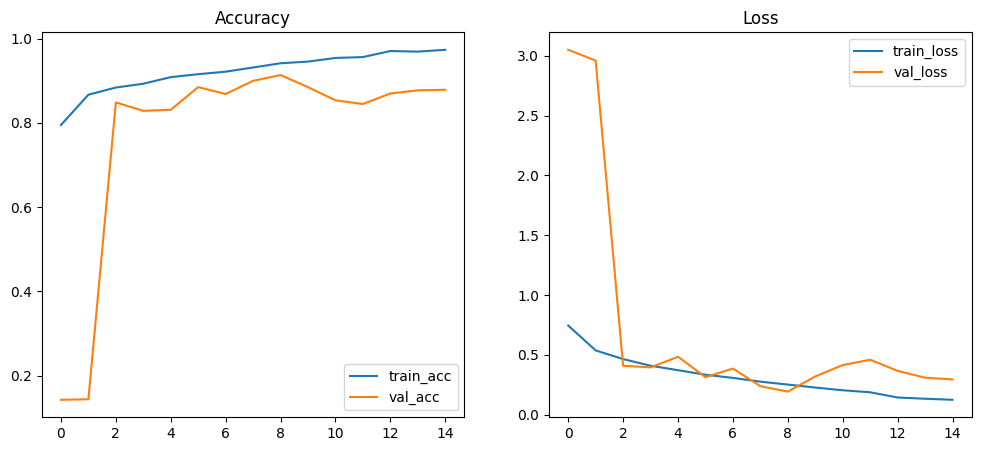

In [19]:
# Cell 12
acc = history.history.get("accuracy", [])
val_acc = history.history.get("val_accuracy", [])
loss = history.history.get("loss", [])
val_loss = history.history.get("val_loss", [])

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()


In [20]:
# Cell 13
model.save(MODEL_SAVE_PATH, include_optimizer=False)
print("Saved model to", MODEL_SAVE_PATH)


Saved model to leukemia_cnn_model.h5


In [21]:
# Cell 14
def predict_image_local(model, img_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
    arr = np.array(img).astype("float32") / 255.0
    arr = np.expand_dims(arr, 0)
    preds = model.predict(arr)[0]
    idx = int(np.argmax(preds))
    return class_names[idx], float(preds[idx]) * 100.0

# Example:
# print(predict_image_local(model, "/path/to/some/sample.jpg"))
